In this notebook, we will be building our model for the open-world experiments to binary classify by determining whether the web traffic trace corresponds to a monitored website or unmonitored website.   

In [79]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import os
import psutil
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

# Extracting Data

To begin, we will first import the dataframes into this notebook. Run either 1 of these blocks

If you are using Google Colab, run this block

In [ ]:
# 1 Use this with colab
print("Loading datafile...")
with open('datasets/extracted_features.pkl', 'rb') as f:
    extracted_df = pickle.load(f)
print ("Data loaded")

If you are using local, run this block

In [81]:
# 2 Use this for local (change the directory to where the extracted_features.pkl is stored on your local machine)
# Load the pickle file
print("Loading datafile...")
# change this directory to the directory where mon_standard.pkl is stored on your local machine
file_path = r'C:\EWHA\Term 2\Machine Learning\pro\neurotic_networkers\extracted_features.pkl' # Jordans local path
with open(file_path, 'rb') as f: # Path to extracted_features.pkl in Colab
    extracted_df = pickle.load(f)
print ("Data loaded")

Loading datafile...
Data loaded


In [82]:
extracted_df

,label,incoming_packet_counts,outgoing_packet_counts,total_packet_counts,incoming_packet_fraction,outgoing_packet_fraction,std_outgoing_order,avg_outgoing_order,sum_concentration,avg_concentration
0,0,1300,121,1421,0.914849,0.085151,515.483953,773.322314,10.14,0.007136
1,0,438,80,518,0.845560,0.154440,139.231951,226.162500,10.16,0.019614
2,0,1240,118,1358,0.913108,0.086892,472.735508,786.110169,11.11,0.008181
3,0,1324,122,1446,0.915629,0.084371,513.916038,820.139344,13.36,0.009239
4,0,1291,115,1406,0.918208,0.081792,503.993490,789.608696,10.64,0.007568
...,...,...,...,...,...,...,...,...,...,...
28995,-1,4180,413,4593,0.910081,0.089919,1173.380403,2549.414044,32.09,0.006987
28996,-1,4663,447,5110,0.912524,0.087476,1621.869237,3062.015660,38.62,0.007558
28997,-1,302,59,361,0.836565,0.163435,118.245320,179.101695,34.93,0.096759
28998,-1,413,96,509,0.811395,0.188605,166.667122,309.197917,11.84,0.023261


We relabel the data such that monitored websites will be labelled as 1 and unmonitored websites will be labelled as 0

In [83]:
relabelled_df = extracted_df.copy()
relabelled_df['label'] = relabelled_df['label'].apply(lambda x: 1 if x>=0 else x)

In [84]:
relabelled_df

,label,incoming_packet_counts,outgoing_packet_counts,total_packet_counts,incoming_packet_fraction,outgoing_packet_fraction,std_outgoing_order,avg_outgoing_order,sum_concentration,avg_concentration
0,1,1300,121,1421,0.914849,0.085151,515.483953,773.322314,10.14,0.007136
1,1,438,80,518,0.845560,0.154440,139.231951,226.162500,10.16,0.019614
2,1,1240,118,1358,0.913108,0.086892,472.735508,786.110169,11.11,0.008181
3,1,1324,122,1446,0.915629,0.084371,513.916038,820.139344,13.36,0.009239
4,1,1291,115,1406,0.918208,0.081792,503.993490,789.608696,10.64,0.007568
...,...,...,...,...,...,...,...,...,...,...
28995,-1,4180,413,4593,0.910081,0.089919,1173.380403,2549.414044,32.09,0.006987
28996,-1,4663,447,5110,0.912524,0.087476,1621.869237,3062.015660,38.62,0.007558
28997,-1,302,59,361,0.836565,0.163435,118.245320,179.101695,34.93,0.096759
28998,-1,413,96,509,0.811395,0.188605,166.667122,309.197917,11.84,0.023261


In [85]:
X_initial = relabelled_df.drop(columns=['label'])
y_initial = relabelled_df['label']

# Constructing Model with all features

Here, we construct a model using all of the features.

In [86]:
# Split data into training and testing sets
X_initial_train, X_initial_test, y_initial_train, y_initial_test = train_test_split(
    X_initial, y_initial, test_size=0.2, random_state=13
)

In [87]:
# Initialize the model
clf_all_features = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=70, min_samples_split=5, max_features="sqrt", random_state=5)

# Train the model
clf_all_features.fit(X_initial_train, y_initial_train)

RandomForestClassifier(criterion='entropy', max_depth=70, min_samples_split=5,
                       random_state=5)

In [88]:
# Create a process object to track current process
process = psutil.Process(os.getpid())
# tracking start time
start_time = time.time()
# Make predictions on the train set
y_initial_train_pred = clf_all_features.predict(X_initial_train)
# tracking end time
end_time = time.time()


time_taken_all_features_train = end_time - start_time
memory_used_all_features_train = process.memory_info().rss / (1024 * 1024)

In [89]:
# Print accuracy and other metrics
print("Memory used:", memory_used_all_features_train, "MB")
print("Time taken to predict:", time_taken_all_features_train, "seconds")
print("Model Accuracy:", accuracy_score(y_initial_train, y_initial_train_pred))
print(classification_report(y_initial_train, y_initial_train_pred))
print("Confusion Matrix")
print(confusion_matrix(y_initial_train, y_initial_train_pred))

Memory used: 472.10546875 MB
Time taken to predict: 0.3318214416503906 seconds
Model Accuracy: 0.9986637931034483
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      8037
           1       1.00      1.00      1.00     15163

    accuracy                           1.00     23200
   macro avg       1.00      1.00      1.00     23200
weighted avg       1.00      1.00      1.00     23200

Confusion Matrix
[[ 8015    22]
 [    9 15154]]


In [90]:
# Create a process object to track current process
process = psutil.Process(os.getpid())
# tracking start time
start_time = time.time()
# Make predictions on the test set
y_initial_test_pred = clf_all_features.predict(X_initial_test)
# tracking end time
end_time = time.time()

time_taken_all_features_test = end_time - start_time
memory_used_all_features_test = process.memory_info().rss / (1024 * 1024)

In [91]:
# Print accuracy and other metrics
print("Memory used:", memory_used_all_features_test, "MB")
print("Time taken to predict:", time_taken_all_features_test, "seconds")
print("Model Accuracy:", accuracy_score(y_initial_test, y_initial_test_pred))
print(classification_report(y_initial_test, y_initial_test_pred))
print("Confusion Matrix")
print(confusion_matrix(y_initial_test, y_initial_test_pred))

Memory used: 472.17578125 MB
Time taken to predict: 0.09753084182739258 seconds
Model Accuracy: 0.7870689655172414
              precision    recall  f1-score   support

          -1       0.73      0.59      0.65      1963
           1       0.81      0.89      0.85      3837

    accuracy                           0.79      5800
   macro avg       0.77      0.74      0.75      5800
weighted avg       0.78      0.79      0.78      5800

Confusion Matrix
[[1153  810]
 [ 425 3412]]


# Feature Importance

In [92]:
df_X = pd.DataFrame(X_initial_train)

In [93]:
df_X.head()

,incoming_packet_counts,outgoing_packet_counts,total_packet_counts,incoming_packet_fraction,outgoing_packet_fraction,std_outgoing_order,avg_outgoing_order,sum_concentration,avg_concentration
10376,2871,266,3137,0.915206,0.084794,964.804851,1328.582707,8.10,0.002582
21698,38,17,55,0.690909,0.309091,16.091864,25.588235,7.72,0.140364
5044,366,33,399,0.917293,0.082707,118.710411,130.666667,6.88,0.017243
24274,8887,1013,9900,0.897677,0.102323,3297.497449,5261.325765,18.26,0.001844
1776,770,117,887,0.868095,0.131905,270.565377,445.837607,12.93,0.014577


In [94]:
# using entropy
model_1= RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=100, min_samples_split=2, max_features="sqrt", random_state=42)
model_1.fit(X_initial_train, y_initial_train)
feature_imp_1 = pd.Series(model_1.feature_importances_, index=df_X.columns)

In [95]:
# using gini
model_2= RandomForestClassifier(n_estimators=100, criterion="gini", max_depth=100, min_samples_split=2, max_features="sqrt", random_state=42)
model_2.fit(X_initial_train, y_initial_train)
feature_imp_2 = pd.Series(model_2.feature_importances_, index=df_X.columns)

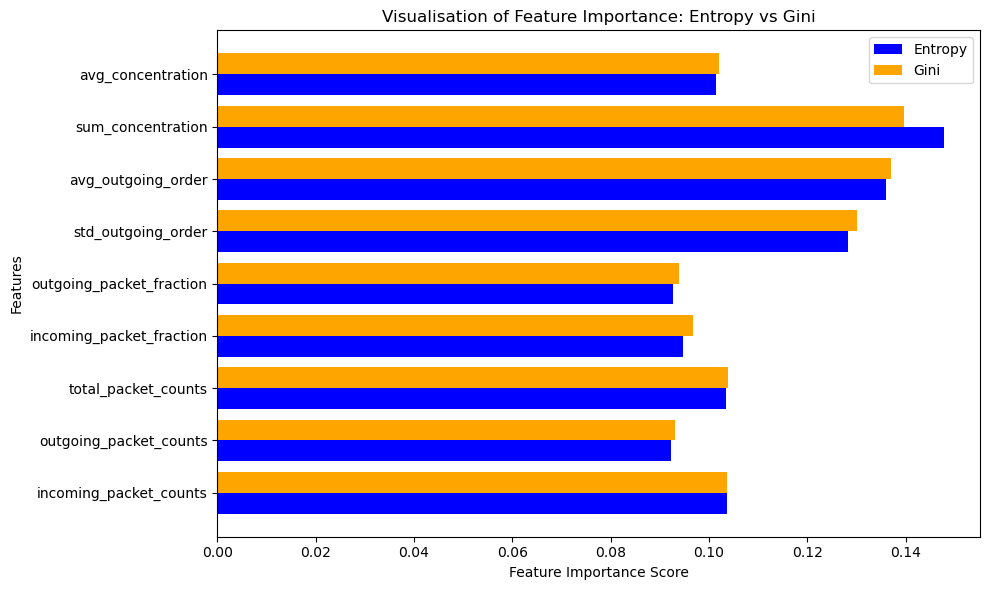

In [96]:
feature_names = df_X.columns
entropy_values = feature_imp_1.values
gini_values = feature_imp_2.values

bar_width = 0.4 
y_positions = range(len(feature_names)) 

plt.figure(figsize=(10,6))

#plotting entropy importance
plt.barh(
    [y - bar_width / 2 for y in y_positions],
    entropy_values,
    bar_width,
    label='Entropy',
    color='blue',
)

# plotting gini improtance
plt.barh(
    [y + bar_width / 2 for y in y_positions],
    gini_values,
    bar_width,
    label='Gini',
    color='orange',
)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.yticks(y_positions, feature_names) 
plt.title('Visualisation of Feature Importance: Entropy vs Gini')
plt.legend()
plt.tight_layout()
plt.show()

Recall the extracted features:
> **Feature Group 1: Traffic Volume (Absolute)**  
> - Feature 1: Number of incoming packets  
> - Feature 2: Number of outgoing packets  
> - Feature 3: Total number of packets  
> 
> **Feature Group 2: Traffic Volume (Fraction)**
> - Feature 1: Number of incoming packets as a fraction of the total number of packets  
> - Feature 2: Number of outgoing packets as a fraction of the total number of packets 
> 
> **Feature Group 3: Traffic Ordering List**
> - Feature 6: Standard deviation of the outgoing packets ordering list  
> - Feature 7: Average of the outgoing packets ordering list  
> 
> **Feature Group 4: Traffic concentration** 
> - Feature 8: Sum of all items in the alternative concentration feature list  
> - Feature 9: Average of all items in the alternative concentration feature list  

We noted that within each of the 4 feature groups, the features are likely to be highly correlated due to their similarity. Furthermore, feature groups 1 and 2 are closely related as well with 1 being an absolute measurement of traffic volume and 2 as the ratio. Hence we will be selecting 2 features from the combination of group 1 and 2, and 1 feature each from group 3 and 4.

According to our feature importance analysis, we have selected the features to be
1. Feature 1: Number of incoming packets   
2. Feature 3: Total number of packets
3. Feature 7: Average of the outgoing packets ordering list 
4. Feature 8: Sum of all items in the alternative concentration feature list  

In [97]:
X = relabelled_df[['incoming_packet_counts', 'total_packet_counts', 'avg_outgoing_order', 'sum_concentration']]
y = relabelled_df['label']

# Constructing Model with selected features

In this section, we construct an arbitrary random forest classification model using arbitrarily chosen parameters. This section aims to explore the implementation of the model. These parameters will be tuned in the next section. 

In [98]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13
)

In [99]:
df = pd.DataFrame(X_train)

In [100]:
df.head()

,incoming_packet_counts,total_packet_counts,avg_outgoing_order,sum_concentration
10376,2871,3137,1328.582707,8.10
21698,38,55,25.588235,7.72
5044,366,399,130.666667,6.88
24274,8887,9900,5261.325765,18.26
1776,770,887,445.837607,12.93


In [101]:
# Initialize the model
clf_selected_features = RandomForestClassifier(n_estimators=100, criterion="entropy", max_depth=70, min_samples_split=5, max_features="sqrt", random_state=5)

# Train the model
clf_selected_features.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=70, min_samples_split=5,
                       random_state=5)

In [102]:
# Create a process object to track current process
process = psutil.Process(os.getpid())
# tracking start time
start_time = time.time()
# Make predictions on the train set
y_train_pred = clf_selected_features.predict(X_train)
# tracking end time
end_time = time.time()


time_taken_selected_features_train = end_time - start_time
memory_used_selected_features_train = process.memory_info().rss / (1024 * 1024)

In [103]:
# Print accuracy and other metrics
print("Memory used:", memory_used_selected_features_train, "MB")
print("Time taken to predict:", time_taken_selected_features_train, "seconds")
print("Model Accuracy:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))
print("Confusion Matrix")
print(confusion_matrix(y_train, y_train_pred))

Memory used: 519.84765625 MB
Time taken to predict: 0.35284972190856934 seconds
Model Accuracy: 0.9972844827586207
              precision    recall  f1-score   support

          -1       1.00      0.99      1.00      8037
           1       1.00      1.00      1.00     15163

    accuracy                           1.00     23200
   macro avg       1.00      1.00      1.00     23200
weighted avg       1.00      1.00      1.00     23200

Confusion Matrix
[[ 7991    46]
 [   17 15146]]


In [104]:
# Create a process object to track current process
process = psutil.Process(os.getpid())
# tracking start time
start_time = time.time()
# Make predictions on the test set
y_test_pred = clf_selected_features.predict(X_test)
# tracking end time
end_time = time.time()


time_taken_selected_features_test = end_time - start_time
memory_used_selected_features_tuned_train = process.memory_info().rss / (1024 * 1024)

In [105]:
# Print accuracy and other metrics
print("Memory used:", memory_used_selected_features_tuned_train, "MB")
print("Time taken to predict:", time_taken_selected_features_test, "seconds")
print("Model Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))

Memory used: 520.2578125 MB
Time taken to predict: 0.10160493850708008 seconds
Model Accuracy: 0.7470689655172413
              precision    recall  f1-score   support

          -1       0.66      0.53      0.59      1963
           1       0.78      0.86      0.82      3837

    accuracy                           0.75      5800
   macro avg       0.72      0.69      0.70      5800
weighted avg       0.74      0.75      0.74      5800

Confusion Matrix
[[1044  919]
 [ 548 3289]]


# Model Tuning

In this section, we will be using Grid Search to tune our model parameters for our Random Forest Classifier

In [106]:
# Defining the parameter grid for the Grid Search
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20],
    'min_samples_split': [10, 15],
    'min_samples_leaf': [5, 10],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'criterion': ['gini', 'entropy']           
}

# Defining the grid search
grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5,  
    refit=True, 
    verbose = 3,
    n_jobs=-1
)

In [107]:
# Fitting the grid search
start_time = time.time()
grid.fit(X_train, y_train)
end_time = time.time()
time_taken_grid_search = end_time - start_time

Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [108]:
# Print the time taken to perform the grid search
print("Time taken for grid search:", time_taken_grid_search, "seconds")

Time taken for grid search: 288.6784951686859 seconds


In [109]:
# Print best parameters after grid search
print("Best parameters found:", grid.best_params_)

Best parameters found: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}


In [110]:
# Create a process object to track current process
process = psutil.Process(os.getpid())
# tracking start time
start_time = time.time()
# Make predictions on the test set
y_train_pred = grid.predict(X_train)
# tracking end time
end_time = time.time()


time_taken_selected_features_tuned_train = end_time - start_time
memory_used_selected_features_tuned_train = process.memory_info().rss / (1024 * 1024)

In [111]:
# Print accuracy and other metrics
print("Memory used:", memory_used_selected_features_tuned_train, "MB")
print("Time taken to predict:", time_taken_selected_features_tuned_train, "seconds")
print("Model Accuracy:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))
print("Confusion Matrix")
print(confusion_matrix(y_train, y_train_pred))

Memory used: 527.9296875 MB
Time taken to predict: 0.2842395305633545 seconds
Model Accuracy: 0.8819396551724138
              precision    recall  f1-score   support

          -1       0.92      0.72      0.81      8037
           1       0.87      0.97      0.91     15163

    accuracy                           0.88     23200
   macro avg       0.89      0.84      0.86     23200
weighted avg       0.89      0.88      0.88     23200

Confusion Matrix
[[ 5808  2229]
 [  510 14653]]


In [112]:
# Create a process object to track current process
process = psutil.Process(os.getpid())
# tracking start time
start_time = time.time()
# Make predictions on the test set
y_test_pred = grid.predict(X_test)
# tracking end time
end_time = time.time()
# tracking end memory


time_taken_selected_features_tuned_test = end_time - start_time
memory_used_selected_features_tuned_test = process.memory_info().rss / (1024 * 1024)

In [113]:
# Print accuracy and other metrics
print("Memory used:", memory_used_selected_features_tuned_test, "MB")
print("Time taken to predict:", time_taken_selected_features_tuned_test, "seconds")
print("Model Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))

Memory used: 528.1015625 MB
Time taken to predict: 0.08085417747497559 seconds
Model Accuracy: 0.7391379310344828
              precision    recall  f1-score   support

          -1       0.66      0.47      0.55      1963
           1       0.76      0.88      0.82      3837

    accuracy                           0.74      5800
   macro avg       0.71      0.67      0.68      5800
weighted avg       0.73      0.74      0.73      5800

Confusion Matrix
[[ 920 1043]
 [ 470 3367]]


In [58]:
with open('datasets/ow_binary.pkl', 'wb') as f:
    pickle.dump(classification_report(y_test, y_test_pred, output_dict=True), f)